![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 4. Ordinal or Ordered Logistic Regression (OLR)

Ordered logistic regression is used when the dependent variable is an ordinal outcome—a categorical variable with a precise rank order but not necessarily equidistant. This method estimates each response level's probability while considering the outcome's ordered nature. Typical applications include customer satisfaction assessment, academic grading, and income classification. In this tutorial, we will discuss ordered logistic regression, manually fit a model to understand its mechanics, and  {statsmodels} library in Python implement the model. We will also examine coefficients, odds ratios, and category thresholds. This tutorial will provide a practical approach to mastering ordinal logistic regression through concepts and hands-on coding.



## Overview

**Ordinal logistic regression (OLR)** is a statistical method used to analyze the relationship between one or more independent variables (predictors) and an ordinal dependent variable. An ordinal variable is a type of categorical variable where the categories have a specific order, but the intervals between the categories are not uniformly measured. This technique is commonly used in social sciences, psychology, and other fields where data is measured on Likert scales (e.g., strongly disagree, disagree, neutral, agree, strongly agree) or in scenarios where outcomes are ordered such as grades (e.g., A, B, C, D, F). OLR allows researchers to understand the impact of independent variables on the likelihood of an outcome falling into a particular category or higher.

In ordinal logistic regression (OLR), the dependent variable is assumed to have three or more ordered categories. The objective is to predict the probability of an observation falling into one of the categories based on the independent variables' values. OLR is an extension of logistic regression, which is used for binary outcomes, and it is designed to handle multiple ordered outcome categories.

The key difference between ordinal variables and nominal variables (which have no inherent order, like colors or types of fruit) is that ordinal variables convey a rank or order.

**Proportional Odds Assumption**: The primary assumption in ordinal logistic regression is that the relationship between each pair of outcome groups is the same across all levels of the independent variables. In other words, the odds ratios comparing any two outcome categories are constant across all levels of the predictor variables.

1.  **Model Specification**:

    -   Let $Y$ be an ordinal variable with $K$ categories. Define $P(Y \leq k)$ as the probability of being in category $k$ or lower.

    -   The model assumes that each category has a threshold $\theta_k$ such that:

  $$ \text{logit}(P(Y \leq k)) = \theta_k - X\beta $$

  for $k = 1, \ldots, K-1$

2.  **Link Function**:

    -   The cumulative logit link function is typically used, so:

$$  P(Y \leq k) = \frac{1}{1 + e^{-(\theta_k - X\beta)}} $$

3.  **Parameter Estimation**:

    -   Maximum likelihood estimation is used to estimate both $\beta$ and \$\theta\_k\$0.

    -   The log-likelihood is based on the cumulative probabilities:

        $$ \mathcal{L}(\beta, \theta) = \sum_{i=1}^n \sum_{k=1}^{K-1} I(Y_i \leq k) \ln(P(Y_i \leq k)) + I(Y_i > k) \ln(1 - P(Y_i \leq k)) $$

4.  **Prediction**:

    -   The model predicts the probability of $Y$ falling within each category by computing $P(Y \leq k)$ for each $k$.

5.  **Interpretation**:

    -   The coefficients $\beta$ represent the change in the log-odds of being in a higher vs. lower category for a one-unit increase in $X$.



## Building a Ordinal Model from Scratch

Fitting an ordinal logistic regression model from scratch in Python without using any external libraries involves several steps, including creating synthetic data, calculating the cumulative probabilities, estimating the model coefficients using Maximum Likelihood Estimation (MLE), and deriving the summary statistics and odds ratios with confidence intervals. Below, I will outline how to accomplish this step-by-step.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Generate Synthetic Data

We'll create a synthetic dataset with 6 continuous predictors, one categorical predictor, and an ordinal response variable with three levels.


In [3]:
n = 1000

# Generate four covariates
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
X3 = np.random.normal(0, 1, n)
X4 = np.random.normal(0, 1, n)

# True coefficients: intercept + 4 predictors
beta_true = np.array([0.5, -1.0, 0.8, -0.6, 1.2])

# Latent variable (linear predictor)
latent = beta_true[0] + beta_true[1]*X1 + beta_true[2]*X2 + beta_true[3]*X3 + beta_true[4]*X4

# Binary outcome with probit link: Y = 1 if latent + noise > 0
Y = (latent + np.random.normal(0, 1, n) > 0).astype(int)

# Create DataFrame
data = pd.DataFrame({'Y': Y, 'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4})
print(data.head())

   Y        X1        X2        X3        X4
0  0  1.797754  0.650588  0.107289 -0.759926
1  1 -0.386105  0.103921 -0.378412  0.435944
2  0  0.858850  0.895860 -0.258410 -0.653804
3  1 -0.438397 -0.252470  0.732019  0.947438
4  0  1.137700 -0.368203  1.545161  0.572556


### Define Model Functions

In [4]:
def log_likelihood(beta, Y, X):
    """
    Negative log-likelihood for Probit model.
    """
    linear_pred = X @ beta
    # Use scipy's norm.cdf for Φ(linear_pred)
    p = norm.cdf(linear_pred)
    # Avoid log(0) by clipping probabilities
    p = np.clip(p, 1e-10, 1 - 1e-10)
    ll = np.sum(Y * np.log(p) + (1 - Y) * np.log(1 - p))
    return -ll  # Minimize negative log-likelihood

def fit_probit(Y, X):
    """
    Fit Probit model using MLE.
    """
    # Add intercept column
    X = np.column_stack([np.ones(X.shape[0]), X])
    
    # Initial guess for parameters
    initial_beta = np.zeros(X.shape[1])
    
    # Optimize using BFGS
    result = minimize(log_likelihood, initial_beta, args=(Y, X), method='BFGS', hess=True)
    
    if not result.success:
        print("Warning: Optimization failed to converge.")
    
    return {
        'coefficients': result.x,
        'hessian': result.hess_inv,  # Approximate Hessian inverse from BFGS
        'convergence': result.success
    }

### Fit Model

In [10]:
# Fit model
X_cols = ['X1', 'X2', 'X3', 'X4']
Y_data = data['Y'].values
X_data = data[X_cols].values

fit = fit_probit(Y_data, X_data)


### Summary Table

In [11]:
def create_summary_table(fit):
    beta_hat = fit['coefficients']
    # Use inverse of Hessian approximation for covariance matrix
    try:
        cov_matrix = fit['hessian']  # BFGS returns inverse Hessian
    except:
        raise ValueError("Hessian not available.")
    
    std_errors = np.sqrt(np.diag(cov_matrix))
    z_values = beta_hat / std_errors
    p_values = 2 * (1 - norm.cdf(np.abs(z_values)))
    
    summary_df = pd.DataFrame({
        'Coefficient': beta_hat,
        'Std.Error': std_errors,
        'z.value': z_values,
        'p.value': p_values
    }, index=['Intercept', 'X1', 'X2', 'X3', 'X4'])
    
    return summary_df

summary_table = create_summary_table(fit)
print("\n=== Probit Model Summary ===")
print(summary_table)


=== Probit Model Summary ===
           Coefficient  Std.Error    z.value  p.value
Intercept     0.511672   0.056559   9.046748      0.0
X1           -0.957057   0.069850 -13.701564      0.0
X2            0.852282   0.064646  13.183805      0.0
X3           -0.672327   0.057621 -11.668139      0.0
X4            1.158007   0.073148  15.831111      0.0


###  Risk Ratio (Approximate)

Risk Ratio (RR) ordinal model is calculated as the ratio of the probability of the event occurring in the treatment group to the probability of the event occurring in the control group.

RR = P(Y=1 | X, Treatment) / P(Y=1 | X, Control)

Where:
- P(Y=1 | X, Treatment) is the predicted probability of the event for the treatment group.
- P(Y=1 | X, Control) is the predicted probability of the event for the control group.

### Odds Ratio (OR)
The Odds Ratio (OR) is another measure used to compare the odds of an event occurring in two groups. It is calculated as:

OR = Odds(Y=1 | X, Treatment) / Odds(Y=1 | X, Control)

Where:
- Odds(Y=1 | X, Treatment) is the odds of the event for the treatment group.
- Odds(Y=1 | X, Control) is the odds of the event for the control group.

In [12]:
coefficients = summary_table['Coefficient']
beta_0 = coefficients['Intercept']
beta_1 = coefficients['X1']

# Predicted probabilities
p_X1 = norm.cdf(beta_0 + beta_1)  # P(Y=1 | X1=1, others=0?)
p_X0 = norm.cdf(beta_0)           # P(Y=1 | X1=0)

approx_risk_ratio = p_X1 / p_X0
print(f"\nApproximate Risk Ratio (X1=1 vs X1=0): {approx_risk_ratio:.4f}")


Approximate Risk Ratio (X1=1 vs X1=0): 0.4716


### Odds Ratio (OR)

The Odds Ratio (OR) is another measure used to compare the odds of an event occurring in two groups. It is calculated as:

OR = Odds(Y=1 | X, Treatment) / Odds(Y=1 | X, Control)

Where:
- Odds(Y=1 | X, Treatment) is the odds of the event for the treatment group.
- Odds(Y=1 | X, Control) is the odds of the event for the control group.

In [15]:
# CALCULATE RISK AND ODDS RATIOS

odds_ratio = np.exp(beta_1)
odds_ratio
print(f"\nApproximate Odds Ratio (X1=1 vs X1=0): {odds_ratio:.4f}")     


Approximate Odds Ratio (X1=1 vs X1=0): 0.3840


### Cross-validation

Cross-validation is a technique used to assess the performance of a model by partitioning the data into subsets, training the model on some subsets, and validating it on the remaining subsets. This process helps to ensure that the model generalizes well to unseen data.

In the context of ordinal regression, cross-validation can be particularly useful for:

1. **Model Selection**: Comparing different ordinal regression models to identify the best-performing one.
2. **Hyperparameter Tuning**: Optimizing model parameters to improve performance.
3. **Performance Estimation**: Providing a more reliable estimate of model performance by reducing the impact of overfitting.

Common cross-validation techniques include k-fold cross-validation, stratified k-fold cross-validation, and leave-one-out cross-validation. Each method has its advantages and is suitable for different types of data and modeling scenarios.

### Model Evaluation

In [17]:
def evaluate_probit_model(Y, X, beta_hat):
    # Add intercept
    X = np.column_stack([np.ones(X.shape[0]), X])
    linear_pred = X @ beta_hat
    probabilities = norm.cdf(linear_pred)
    predictions = (probabilities > 0.5).astype(int)
    
    accuracy = np.mean(predictions == Y)
    
    # Confusion matrix components
    tp = np.sum((predictions == 1) & (Y == 1))
    tn = np.sum((predictions == 0) & (Y == 0))
    fp = np.sum((predictions == 1) & (Y == 0))
    fn = np.sum((predictions == 0) & (Y == 1))
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    evaluation_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Sensitivity', 'Specificity'],
        'Value': [accuracy, sensitivity, specificity]
    })
    
    return evaluation_df

# Evaluate on full dataset
eval_results = evaluate_probit_model(Y_data, X_data, fit['coefficients'])
print("\n=== Model Evaluation ===")
print(eval_results)


=== Model Evaluation ===
        Metric     Value
0     Accuracy  0.846000
1  Sensitivity  0.879252
2  Specificity  0.798544


## Fit Ordinal Logistic Regression in With Python



### Data

Our goal is to develop a Ordinal regression model to predict ordinal class of paddy soil arsenic (non-contaminated, moderately-contaminated and highly-contaminated ) using selected irrigation water and soil properties. We have available data of 263 paired groundwater and paddy soil samples from arsenic contaminated areas in Tala Upazilla, Satkhira district, Bangladesh. This data was utilized in a publication titled "Factors Affecting Paddy Soil Arsenic Concentration in Bangladesh: Prediction and Uncertainty of Geostatistical Risk Mapping" which can be accessed via the this [URL](https://doi.org/10.1016/j.scitotenv.2011.10.008)

Full data set is available for download can download from my [Dropbox](https://www.dropbox.com/scl/fo/2rh6r68i9cxmgortvbw8q/h?rlkey=bvntt66n9mcywprmdki08ch3r&dl=0) or from my [Github](https://github.com/zia207/r-colab/tree/main/Data/Regression_analysis) accounts.



In [18]:
url = "https://github.com/zia207/r-colab/raw/main/Data/Regression_analysis/bd_soil_arsenic.csv"
mf = pd.read_csv(url)

print("Data loaded successfully!")
print(mf.head())

Data loaded successfully!
   ID  Longitude  Latitude    WAs     WP   WFe   WEc   WpH   WMg   WNa  ...  \
0   1    89.1134   22.7544  0.059  0.761  3.44  1.03  7.03  33.9  69.4  ...   
1   2    89.1232   22.7576  0.059  1.194  4.93  1.07  7.06  34.1  74.6  ...   
2   3    89.1281   22.7499  0.079  1.317  9.70  1.40  6.84  40.5  89.4  ...   
3   4    89.1296   22.7568  0.122  1.545  8.58  0.83  6.85  28.4  22.8  ...   
4   5    89.1312   22.7366  0.072  0.966  4.78  1.42  6.95  43.4  93.0  ...   

    SOC     SP  Sand  Silt  Clay  Elevation  Year_Irrigation  Distance_STW  \
0  1.66  13.79  16.3  44.8  38.9          3               14             5   
1  1.26  15.31  11.1  48.7  40.2          5               20             6   
2  1.36  15.54  12.3  46.4  41.3          4               10             5   
3  1.61  16.28  12.7  43.6  43.7          3                8             8   
4  1.26  14.20  12.1  50.9  37.1          5               10             5   

   Land_type  Land_type_ID  
0

#### Convert Continuous Variables into Ordinal

An ordinal variable is a type of categorical variable in which the categories have a natural order or hierarchy. Unlike interval or ratio variables, the intervals between the categories are not necessarily equal or measurable. This means that while the categories have a meaningful sequence or ranking, the differences between the categories may not be consistent or quantifiable.

We will convert `Soil As (SAs)` into three classes:

A. Non-contaminated, SAs \< 14.8 mg/kg

B. Moderately-contaminated, SAs 14.8 - 20 mg/kg

C. Highly-contaminated: SAs \> 20 mg/kg

-   14.8 mg/kg is the upper baseline soil arsenic concentration for Bangladesh [(Ahmed et al, 2011)](https://www.sciencedirect.com/science/article/pii/S0048969711011661?via%3Dihub)

-   20 mg/kg is the permissible limits of arsenic in agricultural soil [(A Heikens, 2006)](https://agris.fao.org/search/en/providers/122621/records/6472474853aa8c8963049da2)



In [19]:
# Define bins and labels
bins = [-float('inf'), 14.8, 20, float('inf')]
labels = ['Non-contaminated', 'Moderately-contaminated', 'Highly-contaminated']

# Create ordinal categorical variable
mf['Class_As'] = pd.cut(mf['SAs'], bins=bins, labels=labels, ordered=True)

print("Distribution of contamination classes:")
print(mf['Class_As'].value_counts().sort_index())

Distribution of contamination classes:
Class_As
Non-contaminated           93
Moderately-contaminated    85
Highly-contaminated        85
Name: count, dtype: int64


#### Data Processing

In [20]:
# Select variables for modeling
selected_cols = [
    'WAs', 'WFe', 'SOC', 'SAoFe',
    'Year_Irrigation', 'Distance_STW',
    'Land_type', 'Class_As'
]

df = mf[selected_cols].copy()

# Convert categorical variables
df['Land_type'] = df['Land_type'].astype('category')
df['Class_As'] = df['Class_As'].astype('category')

# Normalize numerical columns (first 6)
numerical_cols = selected_cols[:6]
df[numerical_cols] = (df[numerical_cols] - df[numerical_cols].min()) / \
                     (df[numerical_cols].max() - df[numerical_cols].min())

print("Processed ")
print(df.head())

Processed 
        WAs       WFe       SOC     SAoFe  Year_Irrigation  Distance_STW  \
0  0.107383  0.180435  0.533333  0.380711         0.684211      0.047619   
1  0.107383  0.342391  0.342857  0.423858         1.000000      0.071429   
2  0.152125  0.860870  0.390476  0.294416         0.473684      0.047619   
3  0.248322  0.739130  0.509524  0.380711         0.368421      0.119048   
4  0.136465  0.326087  0.342857  0.269036         0.473684      0.047619   

  Land_type             Class_As  
0       MHL  Highly-contaminated  
1       MHL  Highly-contaminated  
2       MHL  Highly-contaminated  
3       MHL  Highly-contaminated  
4       MHL  Highly-contaminated  


#### Split Data

In [22]:
from sklearn.model_selection import train_test_split

np.random.seed(101)

# Create interaction for stratification
df['strata'] = df['Land_type'].astype(str) + "_" + df['Class_As'].astype(str)

train, test = train_test_split(
    df,
    test_size=0.3,
    stratify=df['strata'],
    random_state=101
)

train = train.drop(columns=['strata']).reset_index(drop=True)
test = test.drop(columns=['strata']).reset_index(drop=True)

print("Train Class_As proportions:")
print(train['Class_As'].value_counts(normalize=True))

print("\nTest Class_As proportions:")
print(test['Class_As'].value_counts(normalize=True))

Train Class_As proportions:
Class_As
Non-contaminated           0.353261
Moderately-contaminated    0.326087
Highly-contaminated        0.320652
Name: proportion, dtype: float64

Test Class_As proportions:
Class_As
Non-contaminated           0.354430
Highly-contaminated        0.329114
Moderately-contaminated    0.316456
Name: proportion, dtype: float64


### Prepare Features and Target

In [24]:
from sklearn.preprocessing import StandardScaler

feature_cols = [
    'WAs', 'WFe', 'SOC', 'SAoFe',
    'Year_Irrigation', 'Distance_STW',
    'Land_type'
]

# Target: ordinal encoding (0, 1, 2)
class_order = ['Non-contaminated', 'Moderately-contaminated', 'Highly-contaminated']
train['Class_As_ordinal'] = pd.Categorical(train['Class_As'], categories=class_order, ordered=True).codes
test['Class_As_ordinal'] = pd.Categorical(test['Class_As'], categories=class_order, ordered=True).codes

train_y = train['Class_As_ordinal']
test_y = test['Class_As_ordinal']

# Features
X_train = train[feature_cols]
X_test = test[feature_cols]

# One-hot encode Land_type
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)



### Fit an Ordinal Regression Model

We will fit an ordinal regression model using the `OrderedModel` class from the `statsmodels` library.


###  Only Intercept model

In [27]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

# intercept-only (thresholds only)
intercept_model = OrderedModel(
    endog=train_y,
    exog=None,        # ← No features, not even a constant!
    distr='logit'
)

result_intercept = intercept_model.fit(method='bfgs', disp=False)
print(result_intercept.summary())

                             OrderedModel Results                             
Dep. Variable:       Class_As_ordinal   Log-Likelihood:                -201.98
Model:                   OrderedModel   AIC:                             408.0
Method:            Maximum Likelihood   BIC:                             414.4
Date:                Tue, 12 Aug 2025                                         
Time:                        10:37:25                                         
No. Observations:                 184                                         
Df Residuals:                     182                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0/1           -0.6047      0.154     -3.921      0.000      -0.907      -0.302
1/2            0.3042      0.114      2.662      0.0

### Full model with features 

In [28]:
# Now include exog (your features)
full_model = OrderedModel(
    endog=train_y,
    exog=X_train_df,
    distr='logit'
)

result_full = full_model.fit(method='bfgs', disp=False)
print(result_full.summary())

                             OrderedModel Results                             
Dep. Variable:       Class_As_ordinal   Log-Likelihood:                -140.77
Model:                   OrderedModel   AIC:                             299.5
Method:            Maximum Likelihood   BIC:                             328.5
Date:                Tue, 12 Aug 2025                                         
Time:                        10:38:16                                         
No. Observations:                 184                                         
Df Residuals:                     175                                         
Df Model:                           7                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
WAs                 0.3713      0.174      2.139      0.032       0.031       0.712
WFe                 0.7549      0.178

### Likelihood Ratio Test

In [30]:
from scipy import stats

ll_full = result_full.llf
ll_intercept = result_intercept.llf
lr_stat = 2 * (ll_full - ll_intercept)
df_diff = len(result_full.params) - len(result_intercept.params)
p_value = 1 - stats.chi2.cdf(lr_stat, df_diff)

print("Likelihood Ratio Test")
print(f"LR Statistic: {lr_stat:.3f}")
print(f"p-value: {p_value:.2e}")

Likelihood Ratio Test
LR Statistic: 122.415
p-value: 0.00e+00


### Odds Ratios



In [31]:
coef_names = X_train_df.columns
params = result_full.params[:len(coef_names)]
conf_int = result_full.conf_int().loc[coef_names]

or_vals = np.exp(params)
or_ci_lower = np.exp(conf_int.iloc[:, 0])
or_ci_upper = np.exp(conf_int.iloc[:, 1])

or_table = pd.DataFrame({
    'Odds Ratio': or_vals,
    '2.5%': or_ci_lower,
    '97.5%': or_ci_upper
}).round(3)

print("Odds Ratios:")
print(or_table)

Odds Ratios:
                 Odds Ratio   2.5%  97.5%
WAs                   1.450  1.032  2.037
WFe                   2.127  1.501  3.015
SOC                   1.524  1.076  2.158
SAoFe                 0.803  0.586  1.100
Year_Irrigation       2.928  2.021  4.244
Distance_STW          0.822  0.586  1.154
Land_type_MHL         1.989  1.411  2.805


### Training Performance 

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Predict probabilities (returns numpy array)
pred_train_prob = result_full.predict()

# Get predicted class index (0, 1, 2) with highest probability
pred_train_class = np.argmax(pred_train_prob, axis=1)

# Now compute accuracy
acc_train = accuracy_score(train_y, pred_train_class)
print(f"Training Accuracy: {acc_train:.3f}")

# Confusion matrix
cm_train = confusion_matrix(train_y, pred_train_class)
print("Confusion Matrix (Train):")
print(cm_train)

Training Accuracy: 0.658
Confusion Matrix (Train):
[[48 15  2]
 [15 30 15]
 [ 2 14 43]]


### Prediction and Evaluation

In [37]:
pred_test_prob = result_full.predict(X_test_df)
pred_test_class = np.argmax(pred_test_prob, axis=1)

acc_test = accuracy_score(test_y, pred_test_class)
print(f"Test Accuracy: {acc_test:.3f}")

cm_test = confusion_matrix(test_y, pred_test_class)
print("Confusion Matrix (Test):")
print(cm_test)

Test Accuracy: 0.608
Confusion Matrix (Test):
[[20  4  4]
 [ 8 11  6]
 [ 1  8 17]]


### Cross-validation    

In [38]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
cv_accuracies = []

for train_idx, val_idx in skf.split(X_train_df, train_y):
    X_tr, X_val = X_train_df.iloc[train_idx], X_train_df.iloc[val_idx]
    y_tr, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]

    model_cv = OrderedModel(y_tr, X_tr, distr='logit').fit(method='bfgs', disp=False)
    pred = model_cv.predict(X_val).idxmax(axis=1)
    acc = accuracy_score(y_val, pred)
    cv_accuracies.append(acc)

avg_cv_acc = np.mean(cv_accuracies)
print(f"Cross-Validated Accuracy: {avg_cv_acc:.3f} (+/- {np.std(cv_accuracies)*2:.3f})")

Cross-Validated Accuracy: 0.615 (+/- 0.171)


### Visualize Odds Ratios

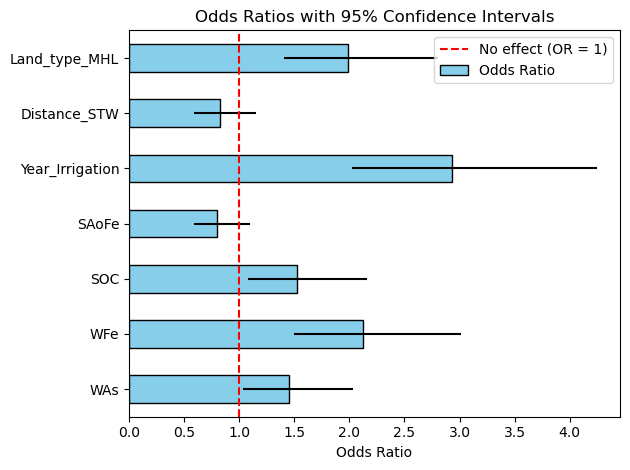

In [40]:
from matplotlib import pyplot as plt

or_table['Odds Ratio'].plot(
    kind='barh',
    xerr=[or_table['Odds Ratio'] - or_table['2.5%'],
          or_table['97.5%'] - or_table['Odds Ratio']],
    color='skyblue',
    edgecolor='black',
    title="Odds Ratios with 95% Confidence Intervals"
)
plt.axvline(x=1, color='red', linestyle='--', label='No effect (OR = 1)')
plt.xlabel("Odds Ratio")
plt.legend()
plt.tight_layout()
plt.show()

 ### Predicted Probabilities by `WAs`

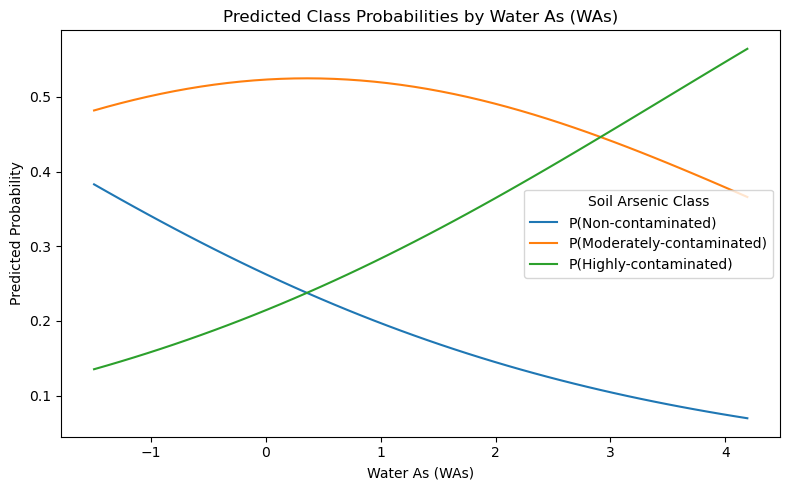

In [ ]:
# Create grid of WAs values
wa_grid = np.linspace(X_train_df['WAs'].min(), X_train_df['WAs'].max(), 50)

# Hold other variables at mean
X_mean = X_train_df.mean().values.reshape(1, -1)
X_grid = np.tile(X_mean, (len(wa_grid), 1))
X_grid[:, X_train_df.columns.get_loc('WAs')] = wa_grid  # Replace WAs column

# Predict probabilities → shape (50, 3)
pred_grid = result_full.predict(X_grid)

# Now plot: each class is a column
class_order = ['Non-contaminated', 'Moderately-contaminated', 'Highly-contaminated']

plt.figure(figsize=(7, 5))
for i, cls in enumerate(class_order):
    plt.plot(wa_grid, pred_grid[:, i], label=f"P({cls})")  # ✅ Use [:, i]

plt.xlabel("Water As (WAs)")
plt.ylabel("Predicted Probability")
plt.title("Predicted Class Probabilities by Water As (WAs)")
plt.legend(title="Soil Arsenic Class")
plt.grid(False)
plt.tight_layout()
plt.show()

### Interpret the Odds Ratios

-   Exponentiate the coefficient: This converts the log odds ratio to an odds ratio. For example, if the coefficient for WAs is 8.195, the odds ratio associated with a one-unit increase in WAs is $e^{8.195}$

-   Interpret the odds ratio: When the odds ratio is greater than 1, it means that for each one-unit increase in the predictor variable, the odds of being in a higher category of the outcome increase by the value of the odds ratio. On the other hand, if the odds ratio is less than 1, it indicates that for each one-unit increase in the predictor variable, the odds of being in a higher category of the outcome decrease by the reciprocal of the odds ratio.

-   Check the significance: When interpreting the results, it's important to pay attention to the p-values associated with each coefficient. A p-value that is less than 0.05 suggests that the odds ratio is significantly different from 1, indicating a strong association between the predictor variable and the outcome category. It's crucial to remember that interpretation should always be done in the context of the specific research question and the nature of the data being analyzed.


### Predicted Probabilities with 95% CI via Bootstrapping

Computing bootstrapped confidence intervals (this may take ~1-2 minutes)...
 Done!


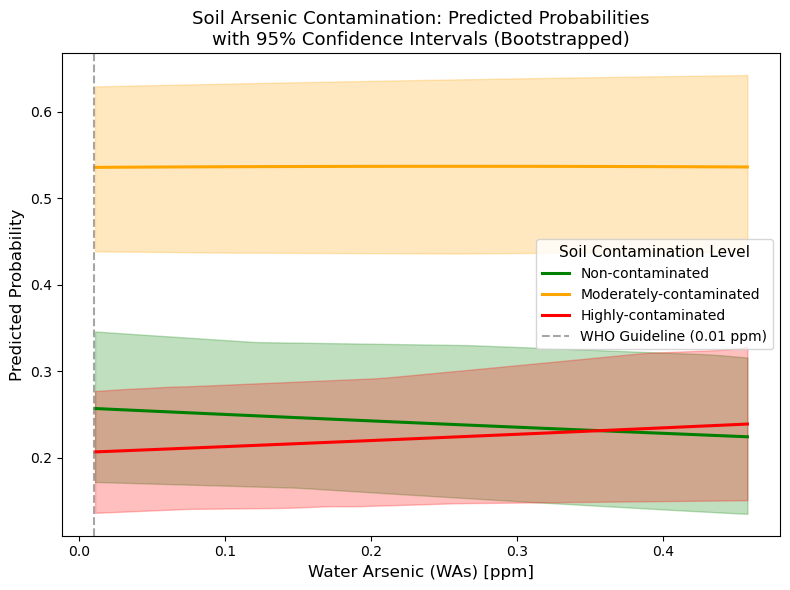

In [46]:
#  Complete: Predicted Probabilities with 95% CI via Bootstrapping

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Set seed
np.random.seed(11076)

def predict_with_bootstrap_ci(X_train_df, train_y, X_new, n_boot=200, alpha=0.05):
    """
    Compute bootstrapped confidence intervals for predicted probabilities.
    """
    n_points = X_new.shape[0]
    n_classes = len(np.unique(train_y))
    predictions = np.zeros((n_boot, n_points, n_classes)) * np.nan

    for i in range(n_boot):
        # Bootstrap sample
        idx = np.random.choice(len(X_train_df), size=len(X_train_df), replace=True)
        X_boot = X_train_df.iloc[idx].copy()
        y_boot = train_y.iloc[idx].copy()

        try:
            model_boot = OrderedModel(endog=y_boot, exog=X_boot, distr='logit')
            result_boot = model_boot.fit(method='bfgs', disp=False, maxiter=100)
            pred = result_boot.predict(X_new)
            pred = pred.values if isinstance(pred, pd.DataFrame) else pred
            predictions[i] = pred
        except Exception:
            continue  # Skip failed fits

    # Compute stats, ignoring NaN
    pred_mean = np.nanmean(predictions, axis=0)
    pred_lower = np.nanquantile(predictions, alpha / 2, axis=0)
    pred_upper = np.nanquantile(predictions, 1 - alpha / 2, axis=0)

    return pred_mean, pred_lower, pred_upper

# --- Define WAs grid in real units (ppm) ---
wa_actual = np.linspace(mf['WAs'].min(), mf['WAs'].max(), 50)

# Scale WAs using training data min/max
w_min, w_max = train['WAs'].min(), train['WAs'].max()
wa_scaled = (wa_actual - w_min) / (w_max - w_min)

# Prepare X_grid: hold all vars at mean, vary only WAs
X_mean_scaled = X_train_df.mean().values.copy()
X_grid = np.tile(X_mean_scaled, (len(wa_scaled), 1))
w_col_idx = X_train_df.columns.get_loc('WAs')
X_grid[:, w_col_idx] = wa_scaled

# --- Compute predictions with CI ---
print("Computing bootstrapped confidence intervals (this may take ~1-2 minutes)...")
pred_mean, pred_lower, pred_upper = predict_with_bootstrap_ci(
    X_train_df, train_y, X_grid, n_boot=200
)
print(" Done!")

# --- Plotting ---
class_order = ['Non-contaminated', 'Moderately-contaminated', 'Highly-contaminated']
colors = ['green', 'orange', 'red']

plt.figure(figsize=(8, 6))
for i, (cls, color) in enumerate(zip(class_order, colors)):
    plt.plot(wa_actual, pred_mean[:, i], label=f"{cls}", color=color, linewidth=2.2)
    plt.fill_between(wa_actual, pred_lower[:, i], pred_upper[:, i],
                     color=color, alpha=0.25)

# Optional: Add guideline
plt.axvline(x=0.01, color='gray', linestyle='--', alpha=0.7, label='WHO Guideline (0.01 ppm)')

plt.xlabel("Water Arsenic (WAs) [ppm]", fontsize=12)
plt.ylabel("Predicted Probability", fontsize=12)
plt.title("Soil Arsenic Contamination: Predicted Probabilities\nwith 95% Confidence Intervals (Bootstrapped)", 
          fontsize=13)
plt.legend(title="Soil Contamination Level", fontsize=10, title_fontsize=11)
plt.grid(False, axis='x')
plt.tight_layout()
plt.show()

## Summary and Conclusion


Understanding ordinal regression and how to implement it in Python can provide valuable insights into the relationships between predictor variables and ordinal response variables. This can lead to a deeper understanding of the factors influencing the outcome of interest. It's important to approach ordinal regression carefully, taking into consideration the specific data and research question.

This notebook has provided a comprehensive overview of ordinal regression, including its theoretical foundations, practical implementation in Python, and interpretation of results. We have explored the use of the `statsmodels` library for fitting ordinal regression models and visualizing the results. 

## References

1. [Ordinal logistic regression](https://www.bookdown.org/rwnahhas/RMPH/blr-ordinal.html)

2. [statsmodels` – `OrderedModel` Documentation](https://www.statsmodels.org/stable/miscmodels.html#module-statsmodels.miscmodels.ordinal_model)

3. [`mord` – Python Library for Ordinal Regression](https://github.com/david-cortes/mord)

4. [Blog: "Ordinal Regression in Python" by David Cortes](https://towardsdatascience.com/ordinal-regression-in-python-ac170a9b410d) 

6. [Chapter 12 Ordinal Logistic Regression](https://bookdown.org/chua/ber642_advanced_regression/ordinal-logistic-regression.html)

7. [Handbook of Regression Modeling in People Analytics:](https://peopleanalytics-regression-book.org/)

Here are some books that cover Ordinal Regression and its implementation in R:

1. **"Modern Applied Statistics with S" by W.N. Venables and B.D. Ripley**
   - This book provides a comprehensive introduction to statistical modeling using S-PLUS and R, including chapters on ordinal regression models.

2. **"Ordinal Data Modeling" by Valen E. Johnson and James H. Albert**
   - This book focuses on ordinal data analysis and modeling, including techniques and applications in R.

3. **"Regression Modeling Strategies: With Applications to Linear Models, Logistic and Ordinal Regression, and Survival Analysis" by Frank E. Harrell Jr.**
   - This comprehensive book covers various regression modeling strategies, including ordinal regression, with practical examples and R code.

4. **"Analysis of Ordinal Categorical Data" by Alan Agresti**
   - This book provides an in-depth look at ordinal categorical data analysis, including ordinal regression models, with examples and code that can be adapted to R.

5. **"Generalized Linear Models with Examples in R" by Peter K. Dunn and Gordon K. Smyth**
   - This book offers a detailed introduction to generalized linear models, including ordinal regression models, with practical examples and R code.

6. **"Applied Ordinal Logistic Regression Using Stata: From Single-Level to Multilevel Modeling" by Xing Liu**
   - While this book primarily focuses on Stata, the concepts and methods discussed can be adapted for implementation in R.

7. **"Applied Regression Analysis and Generalized Linear Models" by John Fox**
   - This book provides a thorough introduction to regression analysis, including ordinal regression, with examples and R code.

These books provide a thorough understanding of ordinal regression models and their application in R, catering to both beginners and advanced users.